# Введение


  **Задача**

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

**Целевая переменная**

Credit Default - факт невыполнения кредитных обязательств

**Метрика качества**

F1-score (sklearn.metrics.f1_score)

**Требования к решению**

Целевая метрика

F1 > 0.5
Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

In [120]:
%matplotlib inline
#импорт используемых библиотек
import pandas as pd
import numpy as np

from scipy import stats
from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats import chi2_contingency
from statsmodels.stats.weightstats import zconfint

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings 
warnings.filterwarnings('ignore')

In [121]:
#Настраиваем отображение данных в таблице, чтобы избавиться от экспоненциального представления данных
pd.set_option('display.float_format', lambda x: '%.2f' % x)

## Используемые функции

In [122]:
def feature_correction(df, basic_feature, feature_to_correct, num1, num2, num3):
    
    #df - датасет, в котором корректируем признаки
    #basic_feature - признак на основе которого корректируем второй признак
    #feature_to_correct - корректируемый признак
    #num1 - значиение1 признака basic_feature на интервале [num1; num2]
    #num2 - значиение2 признака basic_feature на интервале [num1; num2]
    #num3 - значение признака feature_to_correct (num3;...), больше которого требуется исправлять значения
    
    foo = df.loc[(df[basic_feature] >= num1) & (df[basic_feature] <= num2), feature_to_correct].median()
    df.loc[(df[feature_to_correct] > num3)&
             (df[basic_feature] >= num1) & (df[basic_feature] <= num2), feature_to_correct]=foo

In [123]:
def correliation_features(data, list_of_features, target_feature):
    
    #data - датасет, в котором оцениваем признаки
    #list_of_features - список признаков среди которых проводим корреляцию
    #target_feature - целевой признак, для которого оцениваем корреляцию с другими признаками
 
    corr_with_target_feature = data[list_of_features[:-1] + [target_feature]].corr().iloc[:-1,-1].sort_values(ascending = False)

    plt.figure(figsize=(10, 8))

    sns.barplot(x = corr_with_target_feature.values, y = corr_with_target_feature.index)

    plt.title(f'Correlation with {target_feature}')
    plt.show();

In [124]:
def my_chi2_func(data, feature, target_var, feature_num1, feature_num2, id_column = 'ID', sample_var = 1000):
    
    #data - датасет
    #id_column - имя столбца в качестве Id (по умолчанию "ID")
    #feature - рассматриваемый признак
    #target_var - целевая переменная
    #feature_num1 - группа1 признака feature
    #feature_num1 - группа2 признака feature
    #sample_var - размер выборки (по умолчанию 1000)
    
    feature_s = data.loc[data[feature].isin([feature_num1, feature_num2]), [id_column, feature, target_var]].sample(sample_var)
    table = feature_s.pivot_table(values =id_column, index = feature, columns=target_var, aggfunc='count')
    print(table)
    chi2, p, dof, expected = chi2_contingency(table, correction=False) 
    print(f'p_value = {p}.')
    
    if p > 0.05:
        print(f'Группы {feature_num1} и {feature_num2} не оказывают существенного влияния на целевую переменную.')
    else:
        print(f'Группы {feature_num1} и {feature_num2} оказывают существенное влияние на целевую переменную.')

In [125]:
def feature_evaluation(data, feature, target_var, var_boundary=0, sample_value = 1000, check_criteria=True):
    
    #data - датасет, в котором оцениваем признак в разрезе другой переменной
    #feature - оцениваемый признак
    #target_var - целевая переменная в разрезе которой оцениваем признак
    #sample_value - величина выборки (по-умолчанию 1000)
    #var_boundary - величина, по которой разделяется целевая переменная (по умолчанию 0 для бинарных целевых переменных)
    #check_criteria - проверка признаков по критерию Шапиро (по умолчанию True). Чтобы отключить проверку и построить 
    #только один графиr задать False
    
    feature_target_value = df_train[[feature, target_var]].sample(sample_value)
    feature_s = feature_target_value[feature]
    feature_target_value_less_var_boundary = feature_s[feature_target_value[target_var]<= var_boundary]
    feature_target_value_more_var_boundary = feature_s[feature_target_value[target_var] > var_boundary]

    plt.figure(figsize=(10, 5))

    plt.hist(x = feature_s)

    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.title(f'{feature} distribution')
    plt.show()
    
    if check_criteria:
        stat, p_v = shapiro(feature_s)
        print(f'Значение p-value по критерию Шапиро-Уилка = {p_v}.')

        if p_v < 0.05:
            print('Так как значение p-value по критерию Шапиро-Уилка меньше 0.05, соответственно гипотезу ' 
                  'о нормальности отвергаем и сравнивать две выборки будем с помощью критерия Манна-Уитни')
            stat, p_v = mannwhitneyu(feature_target_value_less_var_boundary, feature_target_value_more_var_boundary)

            plt.figure(figsize=(10, 5))

            sns.kdeplot(feature_target_value_less_var_boundary, shade=True, label=f'{target_var} less {var_boundary}', color='g')
            sns.kdeplot(feature_target_value_more_var_boundary, shade=True, label=f'{target_var} more {var_boundary}', color='r')

            plt.xlabel(feature)
            plt.title(f'{feature} grouped by {target_var}')
            plt.legend(title='Target', loc='upper right')
            plt.show()
            if p_v >= 0.05:
                print(f'Графики практически совпадают и значение p-value = {p_v} по критерию Манна-Уитни больше 0.05, '
                      f'значит мы принимаем гипотезу о равности мат. ожиданий и признак {feature} не подходит '
                      f'для заполнения пропущенных значений признака {target_var}.')
            else:
                print(f'Значение p-value = {p_v} по критерию Манна-Уитни меньше 0.05. Гипотезу о равности мат. ожидания принять ' 
                      f'не можем. Используем данный признак для заполнения пропущенных значений признака {target_var}')
        else:
            print('Так как значение p-value по критерию Шапиро-Уилка больше 0.05, соответственно гипотезу ' 
                  'о нормальности принимаем и сравнивать две выборки будем с помощью критерия Стьюдента')

            stat, p_v = ttest_ind(feature_target_value_less_var_boundary, feature_target_value_more_var_boundary)

            plt.figure(figsize=(10, 5))

            sns.kdeplot(feature_target_value_less_var_boundary, shade=True, label=f'{target_var} less {var_boundary}', color='g')
            sns.kdeplot(feature_target_value_more_var_boundary, shade=True, label=f'{target_var} more {var_boundary}', color='r')

            plt.xlabel(feature)
            plt.title(f'{feature} grouped by {target_var}')
            plt.show()
            if p_v >= 0.05:
                print(f'Графики практически совпадают и значение p-value = {p_v} по критерию Стьюдента больше 0.05, '
                      f'значит мы принимаем гипотезу о равности мат. ожиданий и признак {feature} не подходит '
                      f'для заполнения пропущенных значений признака {target_var}.')
            else:
                print(f'Значение p-value = {p_v} по критерию Стюдента меньше 0.05. Гипотезу о равности мат. ожидания '
                      f'принять не можем. Используем данный признак для заполнения пропущенных значений признака {target_var}')

In [126]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('VALID\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

## Датасет

In [127]:
TRAIN_PATH = '../project/course_project/course_project_train.csv'
TEST_PATH = '../project/course_project/course_project_test.csv'

In [128]:
df_train = pd.read_csv(TRAIN_PATH)
df_test = pd.read_csv(TEST_PATH)

 **Описание датасета**

- Home Ownership - домовладение
- Annual Income - годовой доход
- Years in current job - количество лет на текущем месте работы
- Tax Liens - налоговые обременения
- Number of Open Accounts - количество открытых счетов
- Years of Credit History - количество лет кредитной истории
- Maximum Open Credit - наибольший открытый кредит
- Number of Credit Problems - количество проблем с кредитом
- Months since last delinquent - количество месяцев с последней просрочки платежа
- Bankruptcies - банкротства
- Purpose - цель кредита
- Term - срок кредита
- Current Loan Amount - текущая сумма кредита
- Current Credit Balance - текущий кредитный баланс
- Monthly Debt - ежемесячный долг
- Credit Default - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [129]:
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.00,NaN,0.00,11.00,26.30,685960.00,1.00,NaN,1.00,debt consolidation,Short Term,99999999.00,47386.00,7914.00,749.00,0
1,Own Home,1025487.00,10+ years,0.00,15.00,15.30,1181730.00,0.00,NaN,0.00,debt consolidation,Long Term,264968.00,394972.00,18373.00,737.00,1
2,Home Mortgage,751412.00,8 years,0.00,11.00,35.00,1182434.00,0.00,NaN,0.00,debt consolidation,Short Term,99999999.00,308389.00,13651.00,742.00,0
3,Own Home,805068.00,6 years,0.00,8.00,22.50,147400.00,1.00,NaN,1.00,debt consolidation,Short Term,121396.00,95855.00,11338.00,694.00,0
4,Rent,776264.00,8 years,0.00,13.00,13.60,385836.00,1.00,NaN,0.00,debt consolidation,Short Term,125840.00,93309.00,7180.00,719.00,0


In [130]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [131]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 1987 non-null   float64
 2   Years in current job          2414 non-null   object 
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  1142 non-null   float64
 9   Bankruptcies                  2497 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   object 
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

In [132]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = df_train.columns.drop(TARGET_NAME).tolist()

# Анализ данных

## Обзор целевой переменной

In [133]:
df_train['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

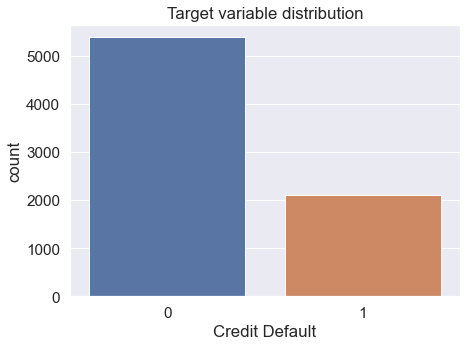

In [134]:
plt.figure(figsize = (7, 5))

sns.countplot(x = 'Credit Default', data = df_train)
plt.title('Target variable distribution')
plt.show()

### Корреляция с базовыми признаками

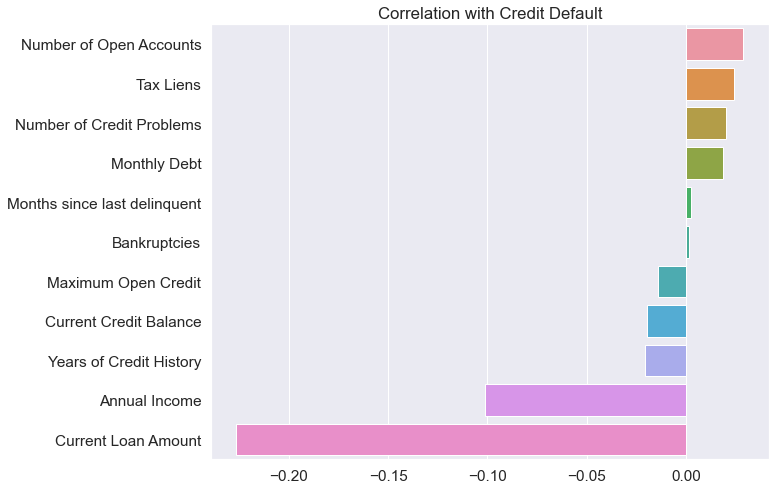

In [135]:
correliation_features(df_train, BASE_FEATURE_NAMES, TARGET_NAME)

Оценку признаков выполним после заполнения пропусков и обработки выбросов

## Обзор количественных признаков

In [136]:
df_train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5943.00,7500.00,7500.00,7500.00,7500.00,7500.00,3419.00,7486.00,7500.00,7500.00,7500.00,5943.00,7500.00
mean,1366391.72,0.03,11.13,18.32,945153.73,0.17,34.69,0.12,11873177.45,289833.24,18314.45,1151.09,0.28
std,845339.20,0.27,4.91,7.04,16026216.67,0.50,21.69,0.35,31926122.97,317871.38,11926.76,1604.45,0.45
min,164597.00,0.00,2.00,4.00,0.00,0.00,0.00,0.00,11242.00,0.00,0.00,585.00,0.00
25%,844341.00,0.00,8.00,13.50,279229.50,0.00,16.00,0.00,180169.00,114256.50,10067.50,711.00,0.00
50%,1168386.00,0.00,10.00,17.00,478159.00,0.00,32.00,0.00,309573.00,209323.00,16076.50,731.00,0.00
75%,1640137.00,0.00,14.00,21.80,793501.50,0.00,50.00,0.00,519882.00,360406.25,23818.00,743.00,1.00
max,10149344.00,7.00,43.00,57.70,1304726170.00,7.00,118.00,4.00,99999999.00,6506797.00,136679.00,7510.00,1.00


In [137]:
feature_num_names = df_train.drop('Credit Default', axis=1).select_dtypes(include=['float64', 'int64']).columns.tolist()
feature_num_names

['Annual Income',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score']

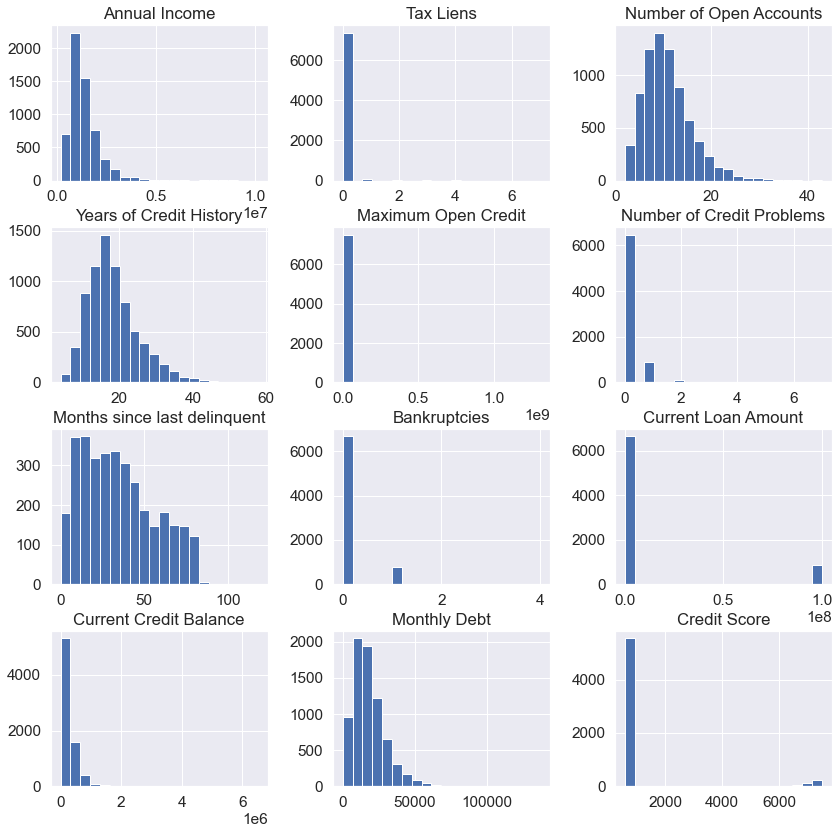

In [138]:
df_train[feature_num_names].hist(figsize=(14,14), bins=20, grid=True);

## Обзор категориальных признаков

In [139]:
for cat_colname in df_train.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(df_train[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation  

### Создание новых признаков на основе категориальных

#### Обработка признака Term

Признак Term переделаем в int, задав значению Short Term = 0, Long Term = 1.

In [140]:
df_train['Term'] = df_train['Term'].replace({'Short Term': 0, 'Long Term': 1})
df_test['Term'] = df_test['Term'].replace({'Short Term': 0, 'Long Term': 1})
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   int64  
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

#### Обработка признака Years in current job

Признак Years in current job аналогично передалаем в int, где новое число будет соответствовать стажу на текущей работе.

In [141]:
foo_dict = { 
    '< 1 year': 0,
    '1 year': 1,
    '2 years': 2,
    '3 years': 3,
    '4 years': 4,
    '5 years': 5,
    '6 years': 6,
    '7 years': 7,
    '8 years': 8,
    '9 years': 9,
    '10+ years': 10,
}

df_train['Years in current job'] = df_train['Years in current job'].replace(foo_dict)
df_test['Years in current job'] = df_test['Years in current job'].replace(foo_dict)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   float64
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   int64  
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

#### Обработка признака Home Ownership

Категориальный признак Home Ownership преобразуем в несколько бинарных.

In [142]:
home_owner = pd.get_dummies(df_train['Home Ownership'])
home_owner

,Have Mortgage,Home Mortgage,Own Home,Rent
0,0,0,1,0
1,0,0,1,0
2,0,1,0,0
3,0,0,1,0
4,0,0,0,1
...,...,...,...,...
7495,0,0,0,1
7496,0,1,0,0
7497,0,0,0,1
7498,0,1,0,0


In [143]:
df_train[home_owner.columns] = home_owner
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Have Mortgage,Home Mortgage,Own Home,Rent
0,Own Home,482087.00,NaN,0.00,11.00,26.30,685960.00,1.00,NaN,1.00,...,0,99999999.00,47386.00,7914.00,749.00,0,0,0,1,0
1,Own Home,1025487.00,10.00,0.00,15.00,15.30,1181730.00,0.00,NaN,0.00,...,1,264968.00,394972.00,18373.00,737.00,1,0,0,1,0
2,Home Mortgage,751412.00,8.00,0.00,11.00,35.00,1182434.00,0.00,NaN,0.00,...,0,99999999.00,308389.00,13651.00,742.00,0,0,1,0,0
3,Own Home,805068.00,6.00,0.00,8.00,22.50,147400.00,1.00,NaN,1.00,...,0,121396.00,95855.00,11338.00,694.00,0,0,0,1,0
4,Rent,776264.00,8.00,0.00,13.00,13.60,385836.00,1.00,NaN,0.00,...,0,125840.00,93309.00,7180.00,719.00,0,0,0,0,1


In [144]:
home_owner = pd.get_dummies(df_test['Home Ownership'])
df_test[home_owner.columns] = home_owner

#### Обработка признаков Purpose

Признак Purpose переделаем в int по схеме "чем больше значений, тем ниже число", т.е. для debt consoidation, для которых больше всего значений, принимаем 0 и т.д. При этом сгруппируем цели следующим образом:
1. business loan,  small business, renewable energy
2. take a trip, moving, vacation
3. buy a car, major purchase, buy house

In [145]:
foo_dict = { 
    'debt consolidation': 0,
    'other': 1,
    'home improvements': 2,
    'business loan': 3,
    'buy a car': 4,
    'medical bills': 5,
    'major purchase': 4, 
    'take a trip': 6,
    'buy house': 4,
    'small business': 3,
    'wedding': 7,
    'moving': 6,
    'educational expenses': 8,
    'vacation': 6,
    'renewable energy': 3,
}

df_train['Purpose'] = df_train['Purpose'].replace(foo_dict)
df_test['Purpose'] = df_test['Purpose'].replace(foo_dict)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   float64
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   int64  
 11  Term                          7500 non-null   int64  
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

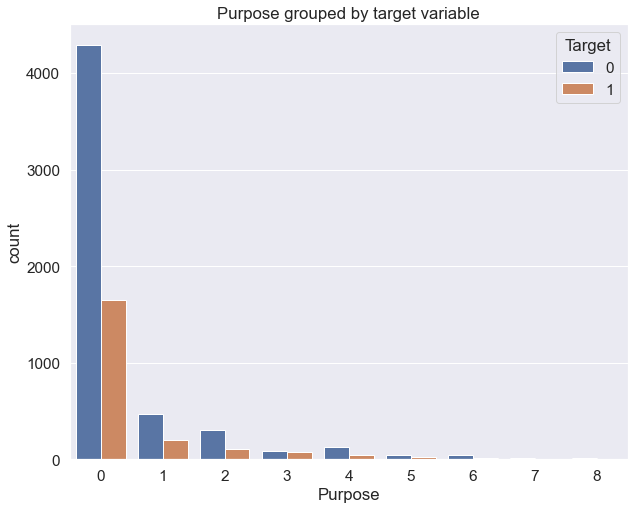

In [146]:
plt.figure(figsize=(10, 8))

sns.countplot(x="Purpose", hue=TARGET_NAME, data=df_train)
plt.title('Purpose grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

In [147]:
my_chi2_func(df_train, 'Purpose', 'Credit Default', 1, 2, id_column='Tax Liens', sample_var=1000)

Credit Default    0    1
Purpose                 
1               435  183
2               283   99
p_value = 0.20700775499346943.
Группы 1 и 2 не оказывают существенного влияния на целевую переменную.


In [148]:
my_chi2_func(df_train, 'Purpose', 'Credit Default', 3, 4, id_column='Tax Liens', sample_var=100)

Credit Default   0   1
Purpose               
3               30  21
4               33  16
p_value = 0.37749480987248507.
Группы 3 и 4 не оказывают существенного влияния на целевую переменную.


In [149]:
my_chi2_func(df_train, 'Purpose', 'Credit Default', 5, 6, id_column='Tax Liens', sample_var=30)

Credit Default  0  1
Purpose             
5               9  8
6               9  4
p_value = 0.3667991499409.
Группы 5 и 6 не оказывают существенного влияния на целевую переменную.


In [150]:
my_chi2_func(df_train, 'Purpose', 'Credit Default', 7, 8, id_column='Tax Liens', sample_var=10)

Credit Default  0
Purpose          
7               5
8               5
p_value = 1.0.
Группы 7 и 8 не оказывают существенного влияния на целевую переменную.


In [151]:
#объединяем группы
foo_dict = { 
    0: 0,
    1: 1,
    2: 1,
    3: 2,
    4: 3,
    5: 4,
    6: 4,
    7: 4,
    8: 4,     
}

df_train['Purpose'] = df_train['Purpose'].replace(foo_dict)
df_test['Purpose'] = df_test['Purpose'].replace(foo_dict)

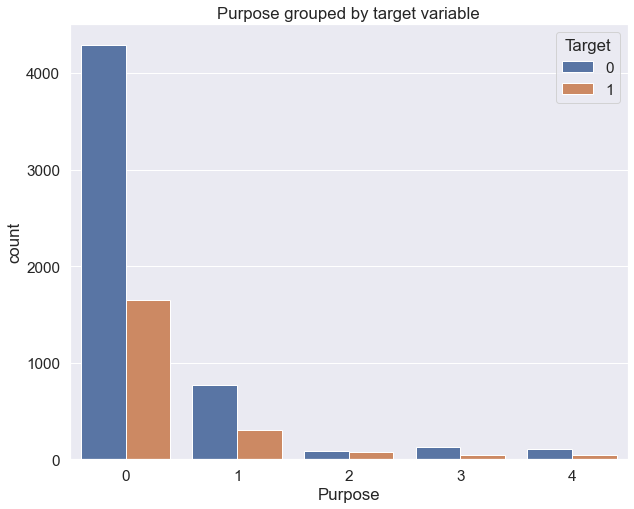

In [152]:
plt.figure(figsize=(10, 8))

sns.countplot(x="Purpose", hue=TARGET_NAME, data=df_train)
plt.title('Purpose grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

In [153]:
my_chi2_func(df_train, 'Purpose', 'Credit Default', 2, 3, id_column='Tax Liens', sample_var=100)

Credit Default   0   1
Purpose               
2               20  22
3               43  15
p_value = 0.00670891867893017.
Группы 2 и 3 оказывают существенное влияние на целевую переменную.


In [154]:
my_chi2_func(df_train, 'Purpose', 'Credit Default', 3, 4, id_column='Tax Liens', sample_var=100)

Credit Default   0   1
Purpose               
3               35  14
4               35  16
p_value = 0.7599349848806843.
Группы 3 и 4 не оказывают существенного влияния на целевую переменную.


In [155]:
#объединяем группы
foo_dict = { 
    0: 0,
    1: 1,
    2: 2,
    3: 3,
    4: 3,       
}

df_train['Purpose'] = df_train['Purpose'].replace(foo_dict)
df_test['Purpose'] = df_test['Purpose'].replace(foo_dict)

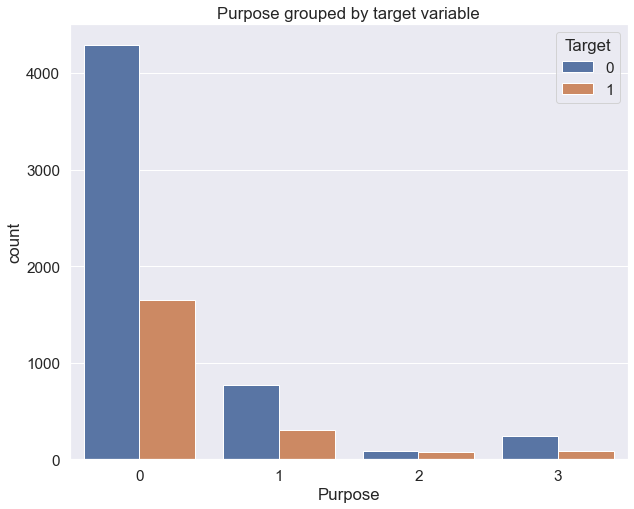

In [156]:
plt.figure(figsize=(10, 8))

sns.countplot(x="Purpose", hue=TARGET_NAME, data=df_train)
plt.title('Purpose grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

## Обработка выбросов

### Обработка выбросов Current Loan Amount

In [157]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   float64
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   int64  
 11  Term                          7500 non-null   int64  
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [158]:
df_train[df_train['Current Loan Amount'] == 99999999].describe()

,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Have Mortgage,Home Mortgage,Own Home,Rent
count,870.00,829.00,870.00,870.00,870.00,870.00,870.00,371.00,867.00,870.00,870.00,870.00,870.00,870.00,870.00,870.00,870.00,870.00,870.00,870.00
mean,1427778.76,5.86,0.02,11.13,18.51,837367.77,0.16,34.73,0.11,0.32,0.17,99999999.00,302859.89,17933.03,730.23,0.00,0.00,0.50,0.09,0.41
std,899883.94,3.61,0.26,4.80,7.02,2096921.52,0.47,21.19,0.34,0.74,0.37,0.00,359087.73,12264.38,21.40,0.00,0.00,0.50,0.29,0.49
min,216714.00,0.00,0.00,2.00,4.80,0.00,0.00,0.00,0.00,0.00,0.00,99999999.00,0.00,0.00,601.00,0.00,0.00,0.00,0.00,0.00
25%,866856.00,2.00,0.00,8.00,13.72,300162.50,0.00,18.00,0.00,0.00,0.00,99999999.00,114522.50,9484.75,726.00,0.00,0.00,0.00,0.00,0.00
50%,1245507.00,6.00,0.00,10.00,17.20,515504.00,0.00,32.00,0.00,0.00,0.00,99999999.00,213465.00,15445.50,737.00,0.00,0.00,1.00,0.00,0.00
75%,1726886.25,10.00,0.00,14.00,22.35,860172.50,0.00,50.00,0.00,0.00,0.00,99999999.00,363370.25,23421.25,744.00,0.00,0.00,1.00,0.00,1.00
max,8758449.00,10.00,6.00,34.00,50.90,40923894.00,6.00,81.00,3.00,3.00,1.00,99999999.00,4249673.00,94674.00,751.00,0.00,0.00,1.00,1.00,1.00


In [159]:
df_train[(df_train['Current Loan Amount'] == 99999999) & (df_train['Maximum Open Credit'] > 0)].head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Have Mortgage,Home Mortgage,Own Home,Rent
0,Own Home,482087.00,NaN,0.00,11.00,26.30,685960.00,1.00,NaN,1.00,...,0,99999999.00,47386.00,7914.00,749.00,0,0,0,1,0
2,Home Mortgage,751412.00,8.00,0.00,11.00,35.00,1182434.00,0.00,NaN,0.00,...,0,99999999.00,308389.00,13651.00,742.00,0,0,1,0,0
6,Home Mortgage,1511108.00,10.00,0.00,9.00,20.30,388124.00,0.00,73.00,0.00,...,0,99999999.00,51623.00,2317.00,745.00,0,0,1,0,0
22,Rent,463790.00,NaN,0.00,6.00,28.30,288442.00,0.00,NaN,0.00,...,0,99999999.00,157700.00,5063.00,738.00,0,0,0,0,1
27,Rent,1004055.00,8.00,0.00,7.00,14.50,328394.00,0.00,NaN,0.00,...,0,99999999.00,195966.00,6041.00,734.00,0,0,0,0,1


Значение 'Current Loan Amount' приравняем к значению 'Maximum Open Credit', т.к. текущая сумма кредита не может быть больше значения Максимально открытого кредита.

In [160]:
df_train.loc[(df_train['Current Loan Amount'] == 99999999) & (df_train['Maximum Open Credit'] > 0), 'Current Loan Amount'] =\
  df_train['Maximum Open Credit']

df_test.loc[(df_test['Current Loan Amount'] == 99999999) & (df_test['Maximum Open Credit'] > 0), 'Current Loan Amount'] =\
  df_train['Maximum Open Credit']

In [161]:
df_train[(df_train['Current Loan Amount'] == 99999999)]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Have Mortgage,Home Mortgage,Own Home,Rent
585,Home Mortgage,4772800.00,8.00,0.00,9.00,35.50,0.00,0.00,NaN,0.00,...,0,99999999.00,0.00,2227.00,747.00,0,0,1,0,0
602,Home Mortgage,5631030.00,1.00,0.00,5.00,17.50,0.00,0.00,NaN,0.00,...,0,99999999.00,60439.00,15485.00,743.00,0,0,1,0,0
1464,Home Mortgage,2432000.00,10.00,0.00,7.00,21.10,0.00,0.00,NaN,0.00,...,0,99999999.00,0.00,284.00,741.00,0,0,1,0,0
1984,Home Mortgage,8758449.00,10.00,0.00,10.00,20.60,0.00,0.00,NaN,0.00,...,0,99999999.00,2759503.00,12919.00,748.00,0,0,1,0,0
2276,Rent,2086067.00,10.00,0.00,6.00,20.30,0.00,0.00,8.00,0.00,...,1,99999999.00,0.00,28822.00,740.00,0,0,0,0,1
2297,Home Mortgage,1263785.00,8.00,0.00,12.00,16.80,0.00,0.00,12.00,0.00,...,0,99999999.00,0.00,30647.00,732.00,0,0,1,0,0
3401,Rent,326154.00,6.00,0.00,2.00,19.10,0.00,0.00,77.00,NaN,...,0,99999999.00,0.00,1245.00,712.00,0,0,0,0,1
4165,Rent,1254513.00,10.00,0.00,6.00,23.40,0.00,0.00,60.00,0.00,...,0,99999999.00,0.00,0.00,748.00,0,0,0,0,1
4962,Own Home,1893464.00,10.00,0.00,8.00,20.70,0.00,0.00,NaN,0.00,...,0,99999999.00,69084.00,6864.00,751.00,0,0,0,1,0


In [162]:
df_train.loc[(df_train['Current Loan Amount'] == 99999999), 'Current Loan Amount'] = df_train['Current Credit Balance']

df_test.loc[(df_test['Current Loan Amount'] == 99999999), 'Current Loan Amount'] =df_train['Current Credit Balance']

In [163]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   float64
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   int64  
 11  Term                          7500 non-null   int64  
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

### Обработка выбросов Maximum Open Credit

In [164]:
df_train[(df_train['Maximum Open Credit'] > df_train['Maximum Open Credit'].quantile(0.999))]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Have Mortgage,Home Mortgage,Own Home,Rent
44,Have Mortgage,1334256.00,10.00,0.00,17.00,15.40,380052288.00,1.00,35.00,0.00,...,0,33110.00,656450.00,34357.00,729.00,0,1,0,0,0
617,Home Mortgage,NaN,3.00,0.00,13.00,27.50,1304726170.00,0.00,NaN,0.00,...,0,529892.00,1126814.00,5492.00,NaN,0,0,1,0,0
2023,Rent,1342825.00,10.00,0.00,12.00,16.30,57562560.00,0.00,NaN,0.00,...,0,166826.00,944547.00,9176.00,749.00,0,0,0,0,1
2617,Home Mortgage,3217802.00,10.00,0.00,12.00,35.50,265512874.00,0.00,NaN,0.00,...,0,50116.00,1834450.00,20272.00,750.00,0,0,1,0,0
2763,Home Mortgage,3377440.00,10.00,0.00,11.00,23.20,40923894.00,0.00,59.00,0.00,...,0,40923894.00,1908550.00,5770.00,743.00,0,0,1,0,0
4769,Home Mortgage,3739960.00,9.00,0.00,7.00,22.80,26343328.00,0.00,NaN,0.00,...,0,757834.00,6506797.00,38023.00,703.00,0,0,1,0,0
5523,Home Mortgage,1520304.00,10.00,0.00,21.00,35.50,21372428.00,0.00,0.00,0.00,...,1,21372428.00,1975012.00,12555.00,728.00,0,0,1,0,0
7026,Home Mortgage,3312365.00,5.00,0.00,13.00,25.30,26406996.00,0.00,50.00,0.00,...,1,26406996.00,2440246.00,39196.00,745.00,0,0,1,0,0


<AxesSubplot:xlabel='Monthly Debt', ylabel='Maximum Open Credit'>

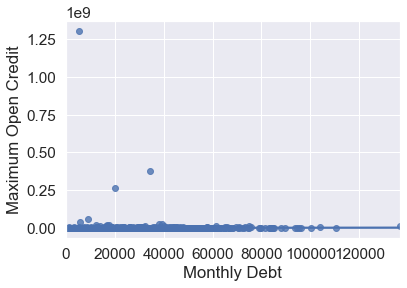

In [165]:
sns.regplot(x = 'Monthly Debt', y = 'Maximum Open Credit', data = df_train)

Выбросы признака Maximum Open Credit, значением больше 0,2е9 заполним медианой.

In [166]:
df_train[(df_train['Maximum Open Credit'] > 0.2e9)]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Have Mortgage,Home Mortgage,Own Home,Rent
44,Have Mortgage,1334256.00,10.00,0.00,17.00,15.40,380052288.00,1.00,35.00,0.00,...,0,33110.00,656450.00,34357.00,729.00,0,1,0,0,0
617,Home Mortgage,NaN,3.00,0.00,13.00,27.50,1304726170.00,0.00,NaN,0.00,...,0,529892.00,1126814.00,5492.00,NaN,0,0,1,0,0
2617,Home Mortgage,3217802.00,10.00,0.00,12.00,35.50,265512874.00,0.00,NaN,0.00,...,0,50116.00,1834450.00,20272.00,750.00,0,0,1,0,0


Выбросы признака заменим медианой для каждой выборки по признаку Monthly Debt.

In [167]:
feature_correction(df = df_train, basic_feature='Monthly Debt', feature_to_correct='Maximum Open Credit',
                   num1=4000, num2=6000, num3=0.2e9)
feature_correction(df = df_test, basic_feature='Monthly Debt', feature_to_correct='Maximum Open Credit',
                   num1=4000, num2=6000, num3=0.2e9)

In [168]:
feature_correction(df = df_train, basic_feature='Monthly Debt', feature_to_correct='Maximum Open Credit',
                   num1=19000, num2=21000, num3=0.2e9)
feature_correction(df = df_test, basic_feature='Monthly Debt', feature_to_correct='Maximum Open Credit',
                   num1=19000, num2=21000, num3=0.2e9)

In [169]:
feature_correction(df = df_train, basic_feature='Monthly Debt', feature_to_correct='Maximum Open Credit',
                   num1=33000, num2=37000, num3=0.2e9)
feature_correction(df = df_test, basic_feature='Monthly Debt', feature_to_correct='Maximum Open Credit',
                   num1=33000, num2=37000, num3=0.2e9)

In [170]:
df_train[(df_train['Maximum Open Credit'] > 0.2e9)]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Have Mortgage,Home Mortgage,Own Home,Rent


<AxesSubplot:xlabel='Monthly Debt', ylabel='Maximum Open Credit'>

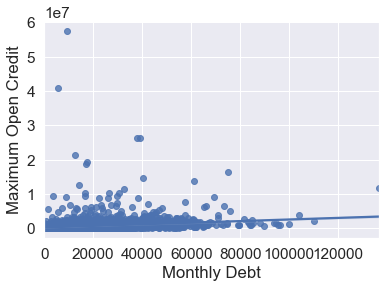

In [171]:
sns.regplot(x = 'Monthly Debt', y = 'Maximum Open Credit', data = df_train)

In [172]:
df_train.describe()

,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Have Mortgage,Home Mortgage,Own Home,Rent
count,5943.00,7129.00,7500.00,7500.00,7500.00,7500.00,7500.00,3419.00,7486.00,7500.00,7500.00,7500.00,7500.00,7500.00,5943.00,7500.00,7500.00,7500.00,7500.00,7500.00
mean,1366391.72,5.88,0.03,11.13,18.32,685330.91,0.17,34.69,0.12,0.31,0.26,370697.43,289833.24,18314.45,1151.09,0.28,0.00,0.48,0.09,0.43
std,845339.20,3.62,0.27,4.91,7.04,1263486.54,0.50,21.69,0.35,0.72,0.44,753842.45,317871.38,11926.76,1604.45,0.45,0.04,0.50,0.28,0.49
min,164597.00,0.00,0.00,2.00,4.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,585.00,0.00,0.00,0.00,0.00,0.00
25%,844341.00,3.00,0.00,8.00,13.50,279229.50,0.00,16.00,0.00,0.00,0.00,177705.00,114256.50,10067.50,711.00,0.00,0.00,0.00,0.00,0.00
50%,1168386.00,6.00,0.00,10.00,17.00,478049.00,0.00,32.00,0.00,0.00,0.00,285549.00,209323.00,16076.50,731.00,0.00,0.00,0.00,0.00,0.00
75%,1640137.00,10.00,0.00,14.00,21.80,793248.50,0.00,50.00,0.00,0.00,1.00,446952.00,360406.25,23818.00,743.00,1.00,0.00,1.00,0.00,1.00
max,10149344.00,10.00,7.00,43.00,57.70,57562560.00,7.00,118.00,4.00,3.00,1.00,40923894.00,6506797.00,136679.00,7510.00,1.00,1.00,1.00,1.00,1.00


## Обработка пропусков

### Заполнение пропусков Annual Income

<AxesSubplot:xlabel='Current Credit Balance', ylabel='Annual Income'>

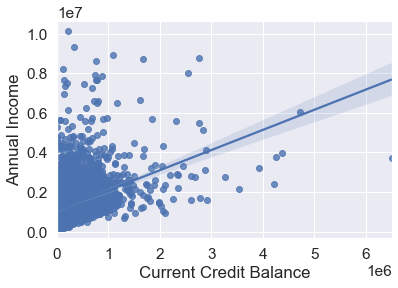

In [173]:
sns.regplot(x = 'Current Credit Balance', y = 'Annual Income', data = df_train)

<AxesSubplot:xlabel='Monthly Debt', ylabel='Annual Income'>

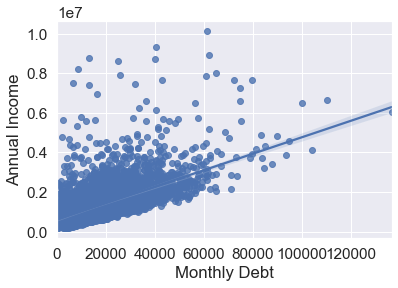

In [174]:
sns.regplot(x = 'Monthly Debt', y = 'Annual Income', data = df_train)

<AxesSubplot:xlabel='Number of Open Accounts', ylabel='Annual Income'>

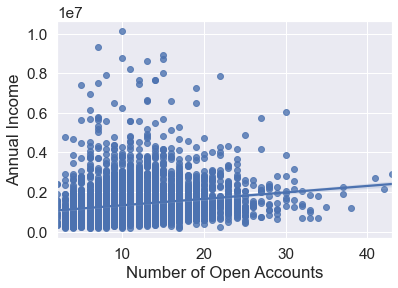

In [175]:
sns.regplot(x = 'Number of Open Accounts', y = 'Annual Income', data = df_train)

В ходе работы выяснилось, что модели Линейной регрессии, RandomForest и GradientBoosting дают показатель R2 в районе 0,35, что является слишком низким показателем, чтобы использовать данные модели для заполенения пропусков 'Annual Income'.

Для заполнения признака 'Annual Income' воспользуемся статистическими показателями по признаку Number of Open Accounts.

In [176]:
pd.concat([df_train.groupby('Number of Open Accounts')['Annual Income'].apply(lambda x: stats.mode(x)),
          df_train.groupby('Number of Open Accounts')['Annual Income'].apply(lambda x: np.median(x)),
          df_train.groupby('Number of Open Accounts')['Annual Income'].apply(lambda x: np.mean(x)),
          df_train.groupby('Number of Open Accounts')['Annual Income'].count(),
          df_train.groupby('Number of Open Accounts')['Annual Income'].apply(lambda x: x.isna().sum())
          ], 
          axis=1, keys=['mode', 'median', 'mean', 'count', 'nan_count']).head()

,mode,median,mean,count,nan_count
Number of Open Accounts,,,,,
2.00,"([316198.0], [1])",NaN,1048010.36,25,3
3.00,"([191577.0], [1])",NaN,912009.50,72,23
4.00,"([497306.0], [2])",NaN,1027034.18,165,47
5.00,"([225112.0], [1])",NaN,1108497.35,263,62
6.00,"([1028242.0], [2])",NaN,1232537.70,395,109


Заполним пропущенные значения 'Annual Income' средним значением.

In [177]:
df_train.loc[df_train['Annual Income'].isna(), 'Annual Income'] =\
  df_train.groupby(['Number of Open Accounts'])['Annual Income'].transform(lambda x: x.mean())

df_test.loc[df_test['Annual Income'].isna(), 'Annual Income'] =\
  df_train.groupby(['Number of Open Accounts'])['Annual Income'].transform(lambda x: x.mean())

In [178]:
df_train.describe()

,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Have Mortgage,Home Mortgage,Own Home,Rent
count,7500.00,7129.00,7500.00,7500.00,7500.00,7500.00,7500.00,3419.00,7486.00,7500.00,7500.00,7500.00,7500.00,7500.00,5943.00,7500.00,7500.00,7500.00,7500.00,7500.00
mean,1366635.47,5.88,0.03,11.13,18.32,685330.91,0.17,34.69,0.12,0.31,0.26,370697.43,289833.24,18314.45,1151.09,0.28,0.00,0.48,0.09,0.43
std,757082.88,3.62,0.27,4.91,7.04,1263486.54,0.50,21.69,0.35,0.72,0.44,753842.45,317871.38,11926.76,1604.45,0.45,0.04,0.50,0.28,0.49
min,164597.00,0.00,0.00,2.00,4.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,585.00,0.00,0.00,0.00,0.00,0.00
25%,927513.50,3.00,0.00,8.00,13.50,279229.50,0.00,16.00,0.00,0.00,0.00,177705.00,114256.50,10067.50,711.00,0.00,0.00,0.00,0.00,0.00
50%,1269632.74,6.00,0.00,10.00,17.00,478049.00,0.00,32.00,0.00,0.00,0.00,285549.00,209323.00,16076.50,731.00,0.00,0.00,0.00,0.00,0.00
75%,1561912.75,10.00,0.00,14.00,21.80,793248.50,0.00,50.00,0.00,0.00,1.00,446952.00,360406.25,23818.00,743.00,1.00,0.00,1.00,0.00,1.00
max,10149344.00,10.00,7.00,43.00,57.70,57562560.00,7.00,118.00,4.00,3.00,1.00,40923894.00,6506797.00,136679.00,7510.00,1.00,1.00,1.00,1.00,1.00


### Заполнение пропусков Bankruptcies

<AxesSubplot:xlabel='Bankruptcies', ylabel='Density'>

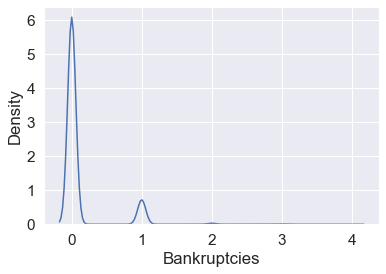

In [179]:
sns.kdeplot(x = 'Bankruptcies', data = df_train)

In [180]:
features_for_bankrupcies = ['Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens', 'Number of Open Accounts',
 'Years of Credit History', 'Maximum Open Credit', 'Number of Credit Problems', 'Months since last delinquent',  'Purpose',
 'Term', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt']

Для определения наиболее сильно влияющего признака составим графи корреляции.

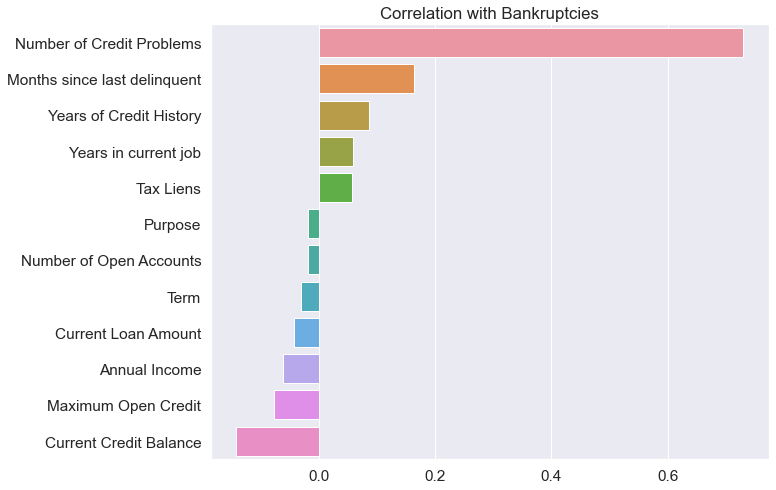

In [181]:
correliation_features(df_train, features_for_bankrupcies, 'Bankruptcies')

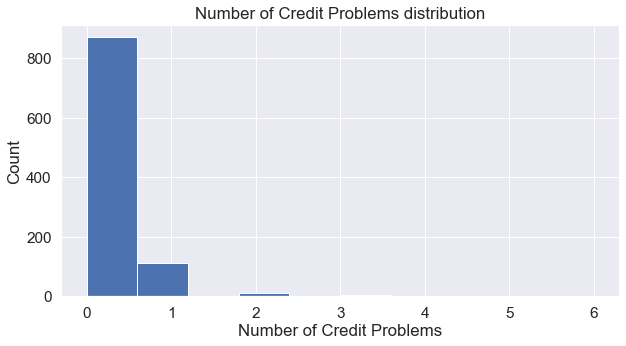

In [182]:
feature_evaluation(data=df_train, feature = 'Number of Credit Problems', target_var = 'Bankruptcies', check_criteria=False)

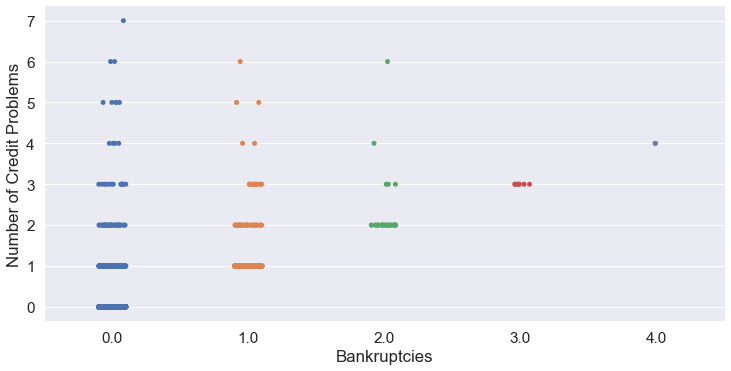

In [183]:
sns.catplot(x = 'Bankruptcies', y = 'Number of Credit Problems',  data=df_train, aspect=2/1);

In [184]:
pd.concat([df_train.groupby('Bankruptcies')['Number of Credit Problems'].apply(lambda x: np.median(x)),
          df_train.groupby('Bankruptcies')['Number of Credit Problems'].apply(lambda x: np.mean(x)),
          df_train.groupby('Bankruptcies')['Number of Credit Problems'].count(),
          df_train.groupby('Bankruptcies')['Number of Credit Problems'].apply(lambda x: x.isna().sum())
          ], 
          axis=1, keys=['mode', 'median', 'mean', 'count', 'nan_count'])

,mode,median,mean,count
Bankruptcies,,,,
0.00,0.00,0.05,6660,0
1.00,1.00,1.09,786,0
2.00,2.00,2.29,31,0
3.00,3.00,3.00,7,0
4.00,4.00,4.00,2,0


In [185]:
pd.concat([df_train.groupby('Number of Credit Problems')['Bankruptcies'].apply(lambda x: np.median(x)),
          df_train.groupby('Number of Credit Problems')['Bankruptcies'].apply(lambda x: np.mean(x)),
          df_train.groupby('Number of Credit Problems')['Bankruptcies'].count(),
          df_train.groupby('Number of Credit Problems')['Bankruptcies'].apply(lambda x: x.isna().sum())
          ], 
          axis=1, keys=['mode', 'median', 'mean', 'count', 'nan_count'])

,mode,median,mean,count
Number of Credit Problems,,,,
0.00,NaN,0.00,6455,14
1.00,1.00,0.84,882,0
2.00,1.00,0.89,93,0
3.00,1.00,1.11,35,0
4.00,1.00,1.33,9,0
5.00,0.00,0.29,7,0
6.00,0.50,0.75,4,0
7.00,0.00,0.00,1,0


In [186]:
pd.concat([df_test.groupby('Number of Credit Problems')['Bankruptcies'].apply(lambda x: np.median(x)),
          df_test.groupby('Number of Credit Problems')['Bankruptcies'].apply(lambda x: np.mean(x)),
          df_test.groupby('Number of Credit Problems')['Bankruptcies'].count(),
          df_test.groupby('Number of Credit Problems')['Bankruptcies'].apply(lambda x: x.isna().sum())
          ], 
          axis=1, keys=['mode', 'median', 'mean', 'count', 'nan_count'])

,mode,median,mean,count
Number of Credit Problems,,,,
0.00,NaN,0.00,2174,3
1.00,1.00,0.79,280,0
2.00,1.00,0.66,29,0
3.00,2.00,1.57,7,0
4.00,4.00,4.00,1,0
5.00,3.00,2.75,4,0
7.00,0.00,0.00,1,0
15.00,0.00,0.00,1,0


Как видим из таблиц выше пропуски значений в столбце банкроств есть только при количестве кредитных проблем равном 0. При этом по статистике при таком значении число банкроств также равно 0, поэтому заполним пропущенные значения 0.

In [187]:
df_train['Bankruptcies'].fillna(0, inplace=True)
df_test['Bankruptcies'].fillna(0, inplace=True)

In [188]:
df_train.describe()

,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Have Mortgage,Home Mortgage,Own Home,Rent
count,7500.00,7129.00,7500.00,7500.00,7500.00,7500.00,7500.00,3419.00,7500.00,7500.00,7500.00,7500.00,7500.00,7500.00,5943.00,7500.00,7500.00,7500.00,7500.00,7500.00
mean,1366635.47,5.88,0.03,11.13,18.32,685330.91,0.17,34.69,0.12,0.31,0.26,370697.43,289833.24,18314.45,1151.09,0.28,0.00,0.48,0.09,0.43
std,757082.88,3.62,0.27,4.91,7.04,1263486.54,0.50,21.69,0.35,0.72,0.44,753842.45,317871.38,11926.76,1604.45,0.45,0.04,0.50,0.28,0.49
min,164597.00,0.00,0.00,2.00,4.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,585.00,0.00,0.00,0.00,0.00,0.00
25%,927513.50,3.00,0.00,8.00,13.50,279229.50,0.00,16.00,0.00,0.00,0.00,177705.00,114256.50,10067.50,711.00,0.00,0.00,0.00,0.00,0.00
50%,1269632.74,6.00,0.00,10.00,17.00,478049.00,0.00,32.00,0.00,0.00,0.00,285549.00,209323.00,16076.50,731.00,0.00,0.00,0.00,0.00,0.00
75%,1561912.75,10.00,0.00,14.00,21.80,793248.50,0.00,50.00,0.00,0.00,1.00,446952.00,360406.25,23818.00,743.00,1.00,0.00,1.00,0.00,1.00
max,10149344.00,10.00,7.00,43.00,57.70,57562560.00,7.00,118.00,4.00,3.00,1.00,40923894.00,6506797.00,136679.00,7510.00,1.00,1.00,1.00,1.00,1.00


### Заполнение пропусков Years in current job

В ходе работы определно, что заполнение признака с помощью регрессионной модели не подходит ввиду низкого коэффициента детерминации в результатах обучения модели и отсутствия линейной зависимости между целевым признаком и признаками, от которых наша целевая зависит. Пропуски заполним медианой.

In [189]:
df_train.describe()

,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Have Mortgage,Home Mortgage,Own Home,Rent
count,7500.00,7129.00,7500.00,7500.00,7500.00,7500.00,7500.00,3419.00,7500.00,7500.00,7500.00,7500.00,7500.00,7500.00,5943.00,7500.00,7500.00,7500.00,7500.00,7500.00
mean,1366635.47,5.88,0.03,11.13,18.32,685330.91,0.17,34.69,0.12,0.31,0.26,370697.43,289833.24,18314.45,1151.09,0.28,0.00,0.48,0.09,0.43
std,757082.88,3.62,0.27,4.91,7.04,1263486.54,0.50,21.69,0.35,0.72,0.44,753842.45,317871.38,11926.76,1604.45,0.45,0.04,0.50,0.28,0.49
min,164597.00,0.00,0.00,2.00,4.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,585.00,0.00,0.00,0.00,0.00,0.00
25%,927513.50,3.00,0.00,8.00,13.50,279229.50,0.00,16.00,0.00,0.00,0.00,177705.00,114256.50,10067.50,711.00,0.00,0.00,0.00,0.00,0.00
50%,1269632.74,6.00,0.00,10.00,17.00,478049.00,0.00,32.00,0.00,0.00,0.00,285549.00,209323.00,16076.50,731.00,0.00,0.00,0.00,0.00,0.00
75%,1561912.75,10.00,0.00,14.00,21.80,793248.50,0.00,50.00,0.00,0.00,1.00,446952.00,360406.25,23818.00,743.00,1.00,0.00,1.00,0.00,1.00
max,10149344.00,10.00,7.00,43.00,57.70,57562560.00,7.00,118.00,4.00,3.00,1.00,40923894.00,6506797.00,136679.00,7510.00,1.00,1.00,1.00,1.00,1.00


In [190]:
df_train['Years in current job'].fillna(df_train['Years in current job'].median(), inplace=True)
df_test['Years in current job'].fillna(df_train['Years in current job'].median(), inplace=True)

In [191]:
df_train.describe()

,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Have Mortgage,Home Mortgage,Own Home,Rent
count,7500.00,7500.00,7500.00,7500.00,7500.00,7500.00,7500.00,3419.00,7500.00,7500.00,7500.00,7500.00,7500.00,7500.00,5943.00,7500.00,7500.00,7500.00,7500.00,7500.00
mean,1366635.47,5.89,0.03,11.13,18.32,685330.91,0.17,34.69,0.12,0.31,0.26,370697.43,289833.24,18314.45,1151.09,0.28,0.00,0.48,0.09,0.43
std,757082.88,3.53,0.27,4.91,7.04,1263486.54,0.50,21.69,0.35,0.72,0.44,753842.45,317871.38,11926.76,1604.45,0.45,0.04,0.50,0.28,0.49
min,164597.00,0.00,0.00,2.00,4.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,585.00,0.00,0.00,0.00,0.00,0.00
25%,927513.50,3.00,0.00,8.00,13.50,279229.50,0.00,16.00,0.00,0.00,0.00,177705.00,114256.50,10067.50,711.00,0.00,0.00,0.00,0.00,0.00
50%,1269632.74,6.00,0.00,10.00,17.00,478049.00,0.00,32.00,0.00,0.00,0.00,285549.00,209323.00,16076.50,731.00,0.00,0.00,0.00,0.00,0.00
75%,1561912.75,10.00,0.00,14.00,21.80,793248.50,0.00,50.00,0.00,0.00,1.00,446952.00,360406.25,23818.00,743.00,1.00,0.00,1.00,0.00,1.00
max,10149344.00,10.00,7.00,43.00,57.70,57562560.00,7.00,118.00,4.00,3.00,1.00,40923894.00,6506797.00,136679.00,7510.00,1.00,1.00,1.00,1.00,1.00


### Заполнение пропусков Months since last delinquent

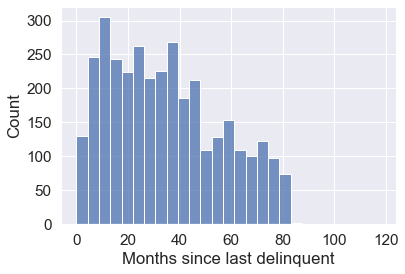

In [192]:
sns.histplot(data = df_train, x = 'Months since last delinquent')
plt.show()

Пропуски в Months since last delinquent также заполним медианным значением.

In [193]:
df_train['Months since last delinquent'].fillna(df_train['Months since last delinquent'].median(), inplace=True)
df_test['Months since last delinquent'].fillna(df_train['Months since last delinquent'].median(), inplace=True)

In [194]:
df_train.describe()

,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Have Mortgage,Home Mortgage,Own Home,Rent
count,7500.00,7500.00,7500.00,7500.00,7500.00,7500.00,7500.00,7500.00,7500.00,7500.00,7500.00,7500.00,7500.00,7500.00,5943.00,7500.00,7500.00,7500.00,7500.00,7500.00
mean,1366635.47,5.89,0.03,11.13,18.32,685330.91,0.17,33.23,0.12,0.31,0.26,370697.43,289833.24,18314.45,1151.09,0.28,0.00,0.48,0.09,0.43
std,757082.88,3.53,0.27,4.91,7.04,1263486.54,0.50,14.70,0.35,0.72,0.44,753842.45,317871.38,11926.76,1604.45,0.45,0.04,0.50,0.28,0.49
min,164597.00,0.00,0.00,2.00,4.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,585.00,0.00,0.00,0.00,0.00,0.00
25%,927513.50,3.00,0.00,8.00,13.50,279229.50,0.00,32.00,0.00,0.00,0.00,177705.00,114256.50,10067.50,711.00,0.00,0.00,0.00,0.00,0.00
50%,1269632.74,6.00,0.00,10.00,17.00,478049.00,0.00,32.00,0.00,0.00,0.00,285549.00,209323.00,16076.50,731.00,0.00,0.00,0.00,0.00,0.00
75%,1561912.75,10.00,0.00,14.00,21.80,793248.50,0.00,32.00,0.00,0.00,1.00,446952.00,360406.25,23818.00,743.00,1.00,0.00,1.00,0.00,1.00
max,10149344.00,10.00,7.00,43.00,57.70,57562560.00,7.00,118.00,4.00,3.00,1.00,40923894.00,6506797.00,136679.00,7510.00,1.00,1.00,1.00,1.00,1.00


### Заполнение пропусков Credit Score

<AxesSubplot:xlabel='Credit Score', ylabel='Density'>

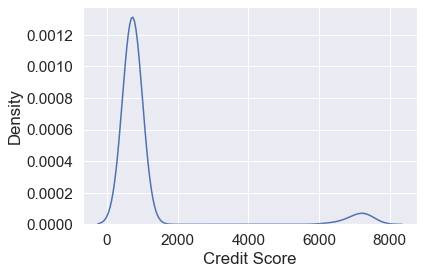

In [195]:
sns.kdeplot(x = 'Credit Score', data = df_train)

**Корреляция с другими признаками**

In [196]:
BASE_FEATURE_NAMES = df_train.columns.drop([TARGET_NAME, 'Credit Score', 'Home Ownership']).tolist()
BASE_FEATURE_NAMES

['Annual Income',
 'Years in current job',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Purpose',
 'Term',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Have Mortgage',
 'Home Mortgage',
 'Own Home',
 'Rent']

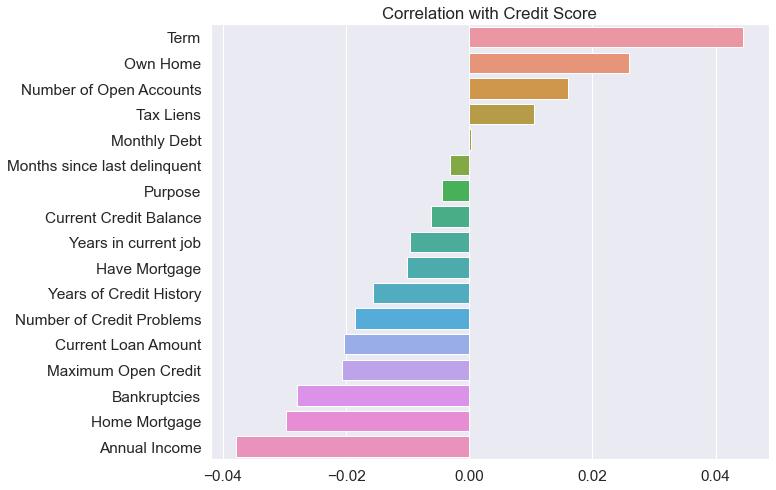

In [197]:
correliation_features(df_train, BASE_FEATURE_NAMES, 'Credit Score')

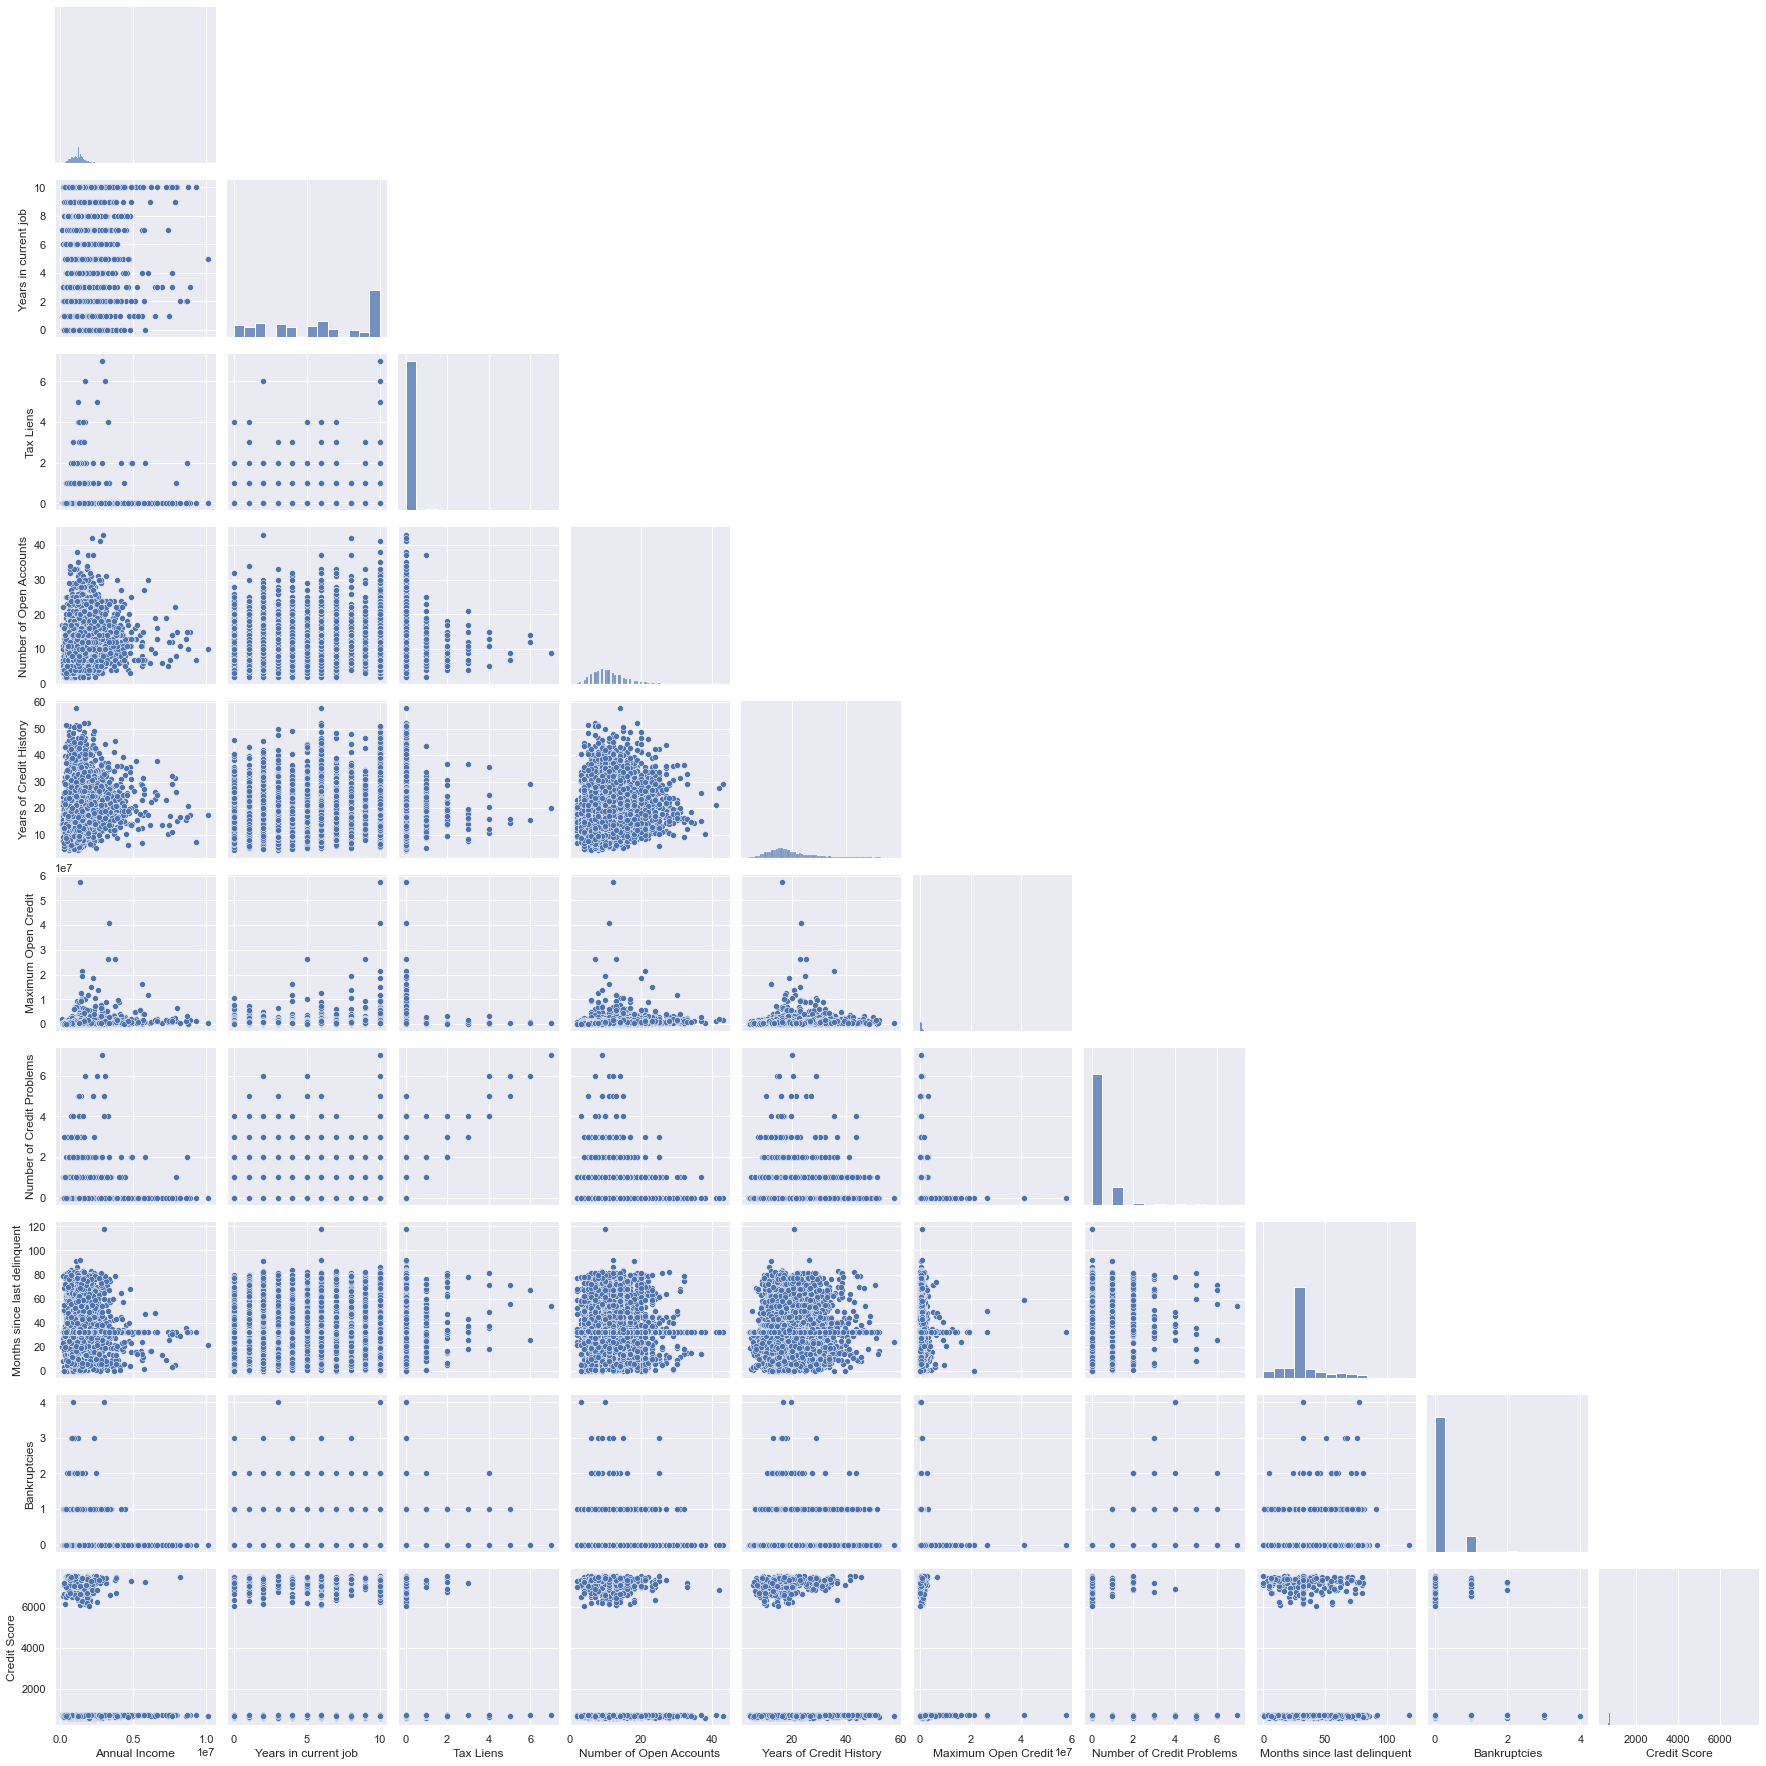

In [198]:
sns.set()
sns.pairplot(df_train[BASE_FEATURE_NAMES[:9] + ['Credit Score']], corner=True);

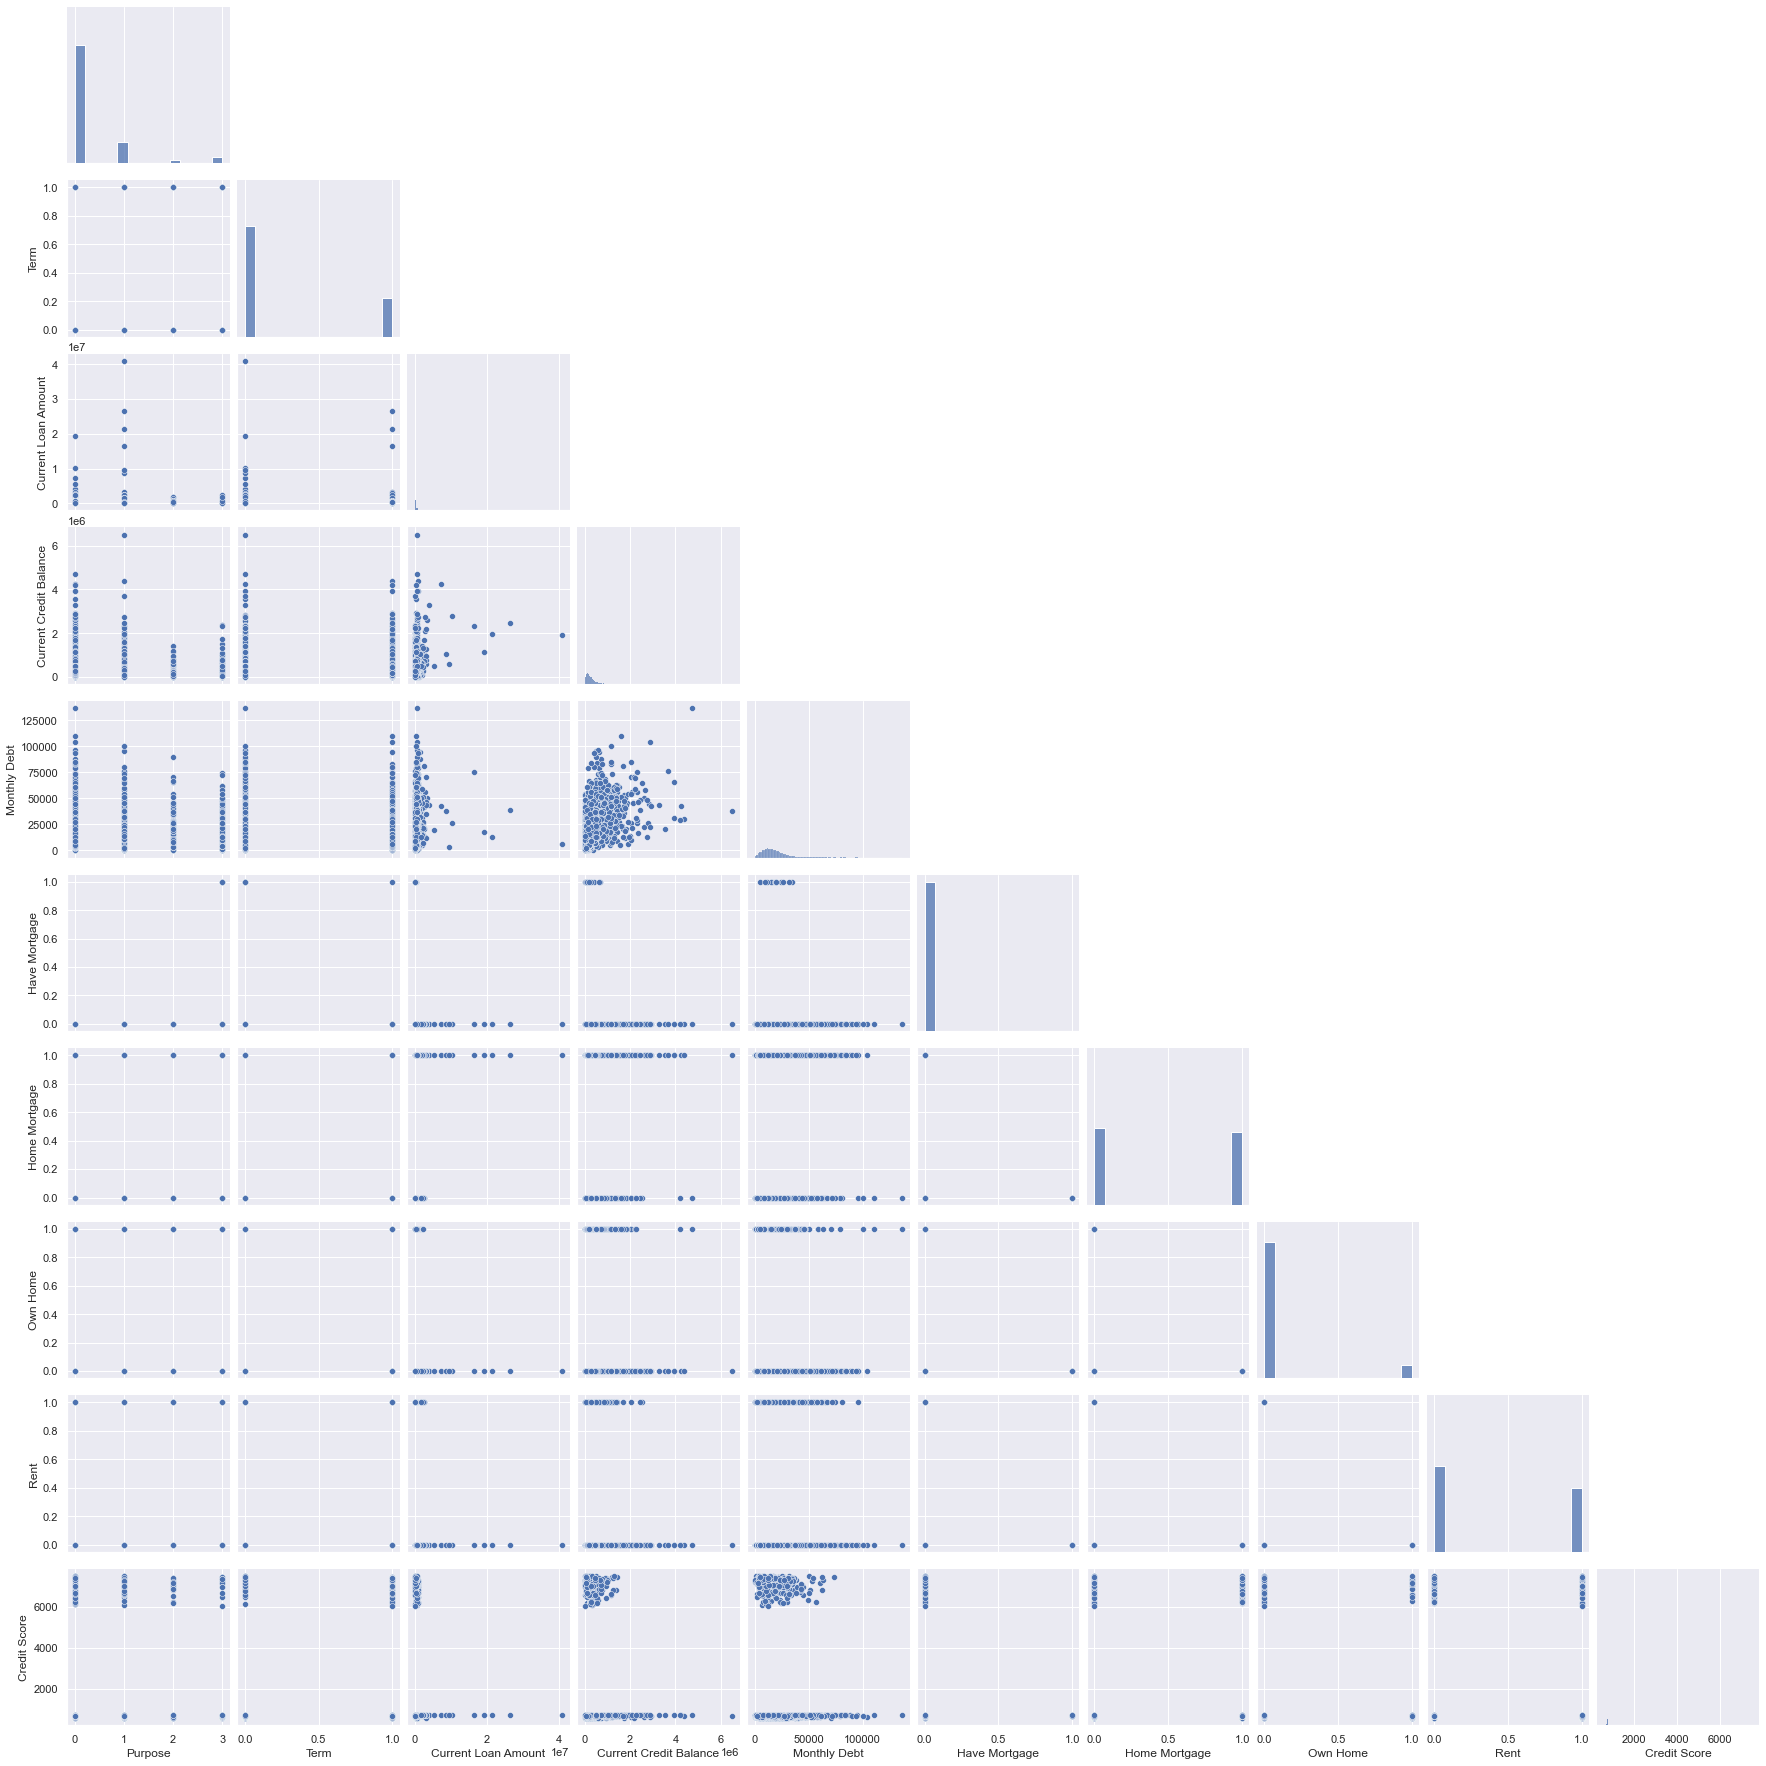

In [199]:
sns.set()
sns.pairplot(df_train[BASE_FEATURE_NAMES[9:] + ['Credit Score']], corner=True);

Создадим бинарный признак из Credit score в котором 0 будет соответствовать значениям меньше 4000, 1 - больше 4000.

In [200]:
bin_score = [0, 4001, 8000]
label_score = [0, 1]

df_train['Credit Score bin'] = pd.cut(df_train['Credit Score'], bins = bin_score, labels=label_score, ordered=False)
df_test['Credit Score bin'] = pd.cut(df_test['Credit Score'], bins = bin_score, labels=label_score, ordered=False)
df_train['Credit Score bin'].value_counts()

0    5543
1     400
Name: Credit Score bin, dtype: int64

Заменим пропуски признака Credit Score bin модой, равной 0.

In [201]:
df_train['Credit Score bin'].fillna(0, inplace=True)
df_test['Credit Score bin'].fillna(0, inplace=True)

In [202]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   Home Ownership                7500 non-null   object  
 1   Annual Income                 7500 non-null   float64 
 2   Years in current job          7500 non-null   float64 
 3   Tax Liens                     7500 non-null   float64 
 4   Number of Open Accounts       7500 non-null   float64 
 5   Years of Credit History       7500 non-null   float64 
 6   Maximum Open Credit           7500 non-null   float64 
 7   Number of Credit Problems     7500 non-null   float64 
 8   Months since last delinquent  7500 non-null   float64 
 9   Bankruptcies                  7500 non-null   float64 
 10  Purpose                       7500 non-null   int64   
 11  Term                          7500 non-null   int64   
 12  Current Loan Amount           7500 non-null   fl

Пропуски признака Credit Score заполним по среднему значению признака Credit Score bin равному 0.

In [203]:
df_train.groupby('Credit Score bin')['Credit Score'].apply(lambda x: np.mean(x))

Credit Score bin
0    720.71
1   7115.10
Name: Credit Score, dtype: float64

In [204]:
df_train.loc[df_train['Credit Score'].isna(), 'Credit Score'] =\
  df_train.groupby(['Credit Score bin'])['Credit Score'].transform(lambda x: x.mean())

df_test.loc[df_test['Credit Score'].isna(), 'Credit Score'] =\
  df_train.groupby(['Credit Score bin'])['Credit Score'].transform(lambda x: x.mean())

In [205]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   Home Ownership                7500 non-null   object  
 1   Annual Income                 7500 non-null   float64 
 2   Years in current job          7500 non-null   float64 
 3   Tax Liens                     7500 non-null   float64 
 4   Number of Open Accounts       7500 non-null   float64 
 5   Years of Credit History       7500 non-null   float64 
 6   Maximum Open Credit           7500 non-null   float64 
 7   Number of Credit Problems     7500 non-null   float64 
 8   Months since last delinquent  7500 non-null   float64 
 9   Bankruptcies                  7500 non-null   float64 
 10  Purpose                       7500 non-null   int64   
 11  Term                          7500 non-null   int64   
 12  Current Loan Amount           7500 non-null   fl

Все пропуски заполнены. Перед обучением модели  преобразуем признак Credit Score bin в числовой

In [206]:
df_train['Credit Score bin'] = df_train['Credit Score bin'].astype(int)
df_test['Credit Score bin'] = df_test['Credit Score bin'].astype(int)

In [207]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 7500 non-null   float64
 2   Years in current job          7500 non-null   float64
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  7500 non-null   float64
 9   Bankruptcies                  7500 non-null   float64
 10  Purpose                       7500 non-null   int64  
 11  Term                          7500 non-null   int64  
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [208]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 2500 non-null   float64
 2   Years in current job          2500 non-null   float64
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  2500 non-null   float64
 9   Bankruptcies                  2500 non-null   float64
 10  Purpose                       2500 non-null   int64  
 11  Term                          2500 non-null   int64  
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

## Корреляция целевой переменной

In [209]:
USED_FEATURE_NAMES = df_train.columns.drop([TARGET_NAME, 'Home Ownership']).tolist()
USED_FEATURE_NAMES

['Annual Income',
 'Years in current job',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Purpose',
 'Term',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score',
 'Have Mortgage',
 'Home Mortgage',
 'Own Home',
 'Rent',
 'Credit Score bin']

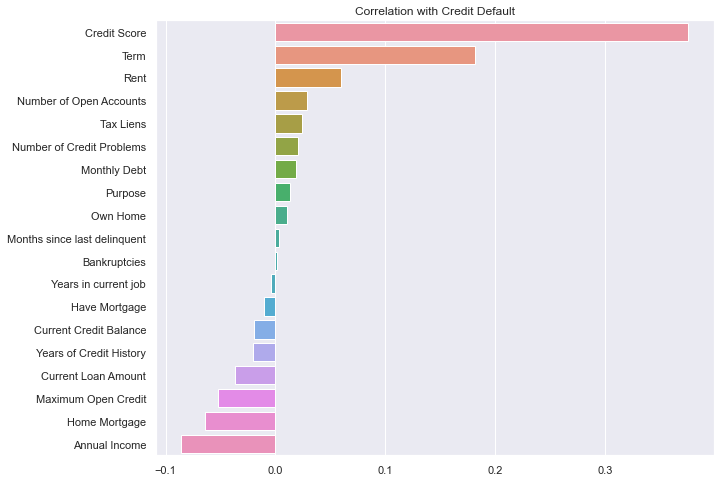

In [210]:
correliation_features(df_train, USED_FEATURE_NAMES, TARGET_NAME)

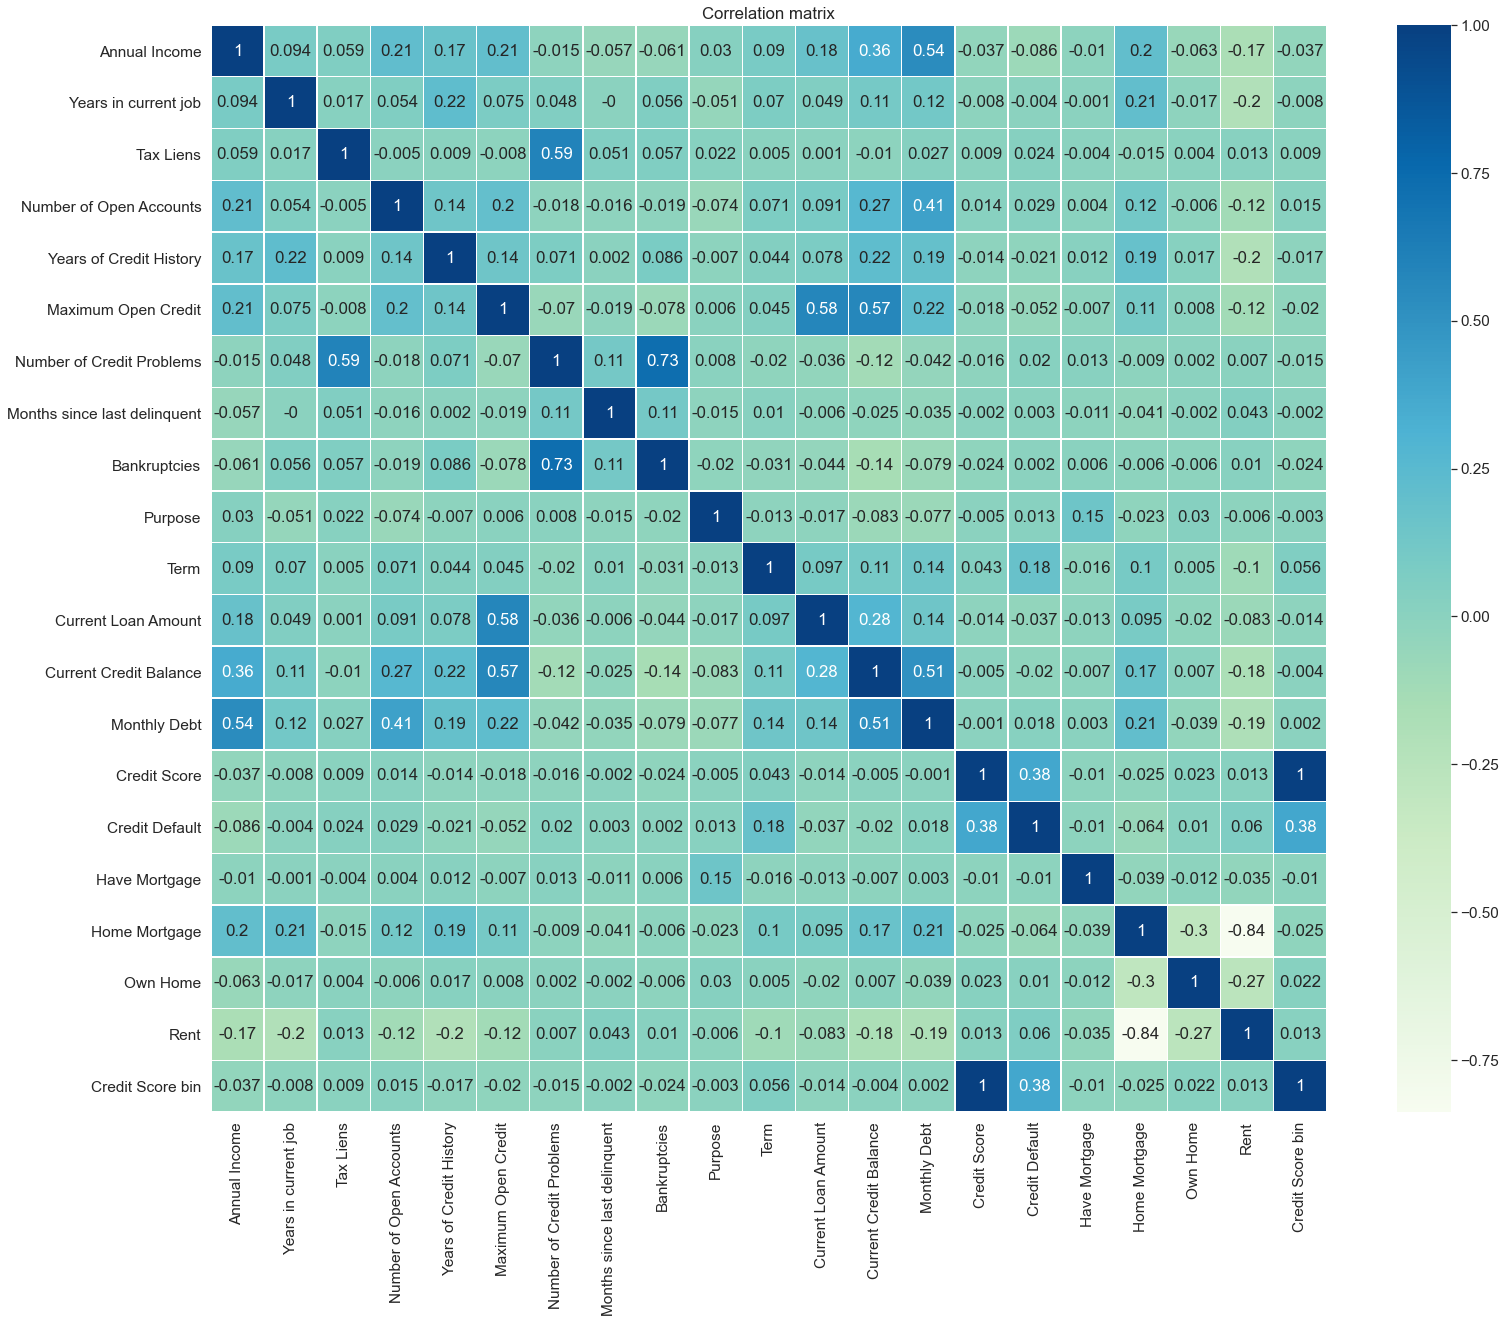

In [211]:
plt.figure(figsize = (25,20))

sns.set(font_scale=1.4)
sns.heatmap(df_train.corr().round(3), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

Как видим, наибольшая корреляции идет с признаком Credit Score и Credit Score bin. необходимость последнего признака проверим в ходе обучения моделей.

# Обучение моделей

## Нормализация признаков

In [226]:
scaler = StandardScaler()

df_scal = df_train.copy()
df_scal[USED_FEATURE_NAMES] = scaler.fit_transform(df_scal[USED_FEATURE_NAMES])
df_test_scal = df_test.copy()
df_test_scal[USED_FEATURE_NAMES] = scaler.transform(df_test_scal[USED_FEATURE_NAMES])

df = df_scal.copy()

In [94]:
df.describe()

,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,...,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Have Mortgage,Home Mortgage,Own Home,Rent,Credit Score bin
count,7500.00,7500.00,7500.00,7500.00,7500.00,7500.00,7500.00,7500.00,7500.00,7500.00,...,7500.00,7500.00,7500.00,7500.00,7500.00,7500.00,7500.00,7500.00,7500.00,7500.00
mean,-0.00,-0.00,-0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,...,-0.00,0.00,0.00,-0.00,0.28,-0.00,0.00,-0.00,-0.00,0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,0.45,1.00,1.00,1.00,1.00,1.00
min,-1.59,-1.67,-0.11,-1.86,-2.03,-0.54,-0.34,-2.26,-0.34,-0.44,...,-0.49,-0.91,-1.54,-0.33,0.00,-0.04,-0.97,-0.31,-0.86,-0.24
25%,-0.58,-0.82,-0.11,-0.64,-0.68,-0.32,-0.34,-0.08,-0.34,-0.44,...,-0.26,-0.55,-0.69,-0.24,0.00,-0.04,-0.97,-0.31,-0.86,-0.24
50%,-0.13,0.03,-0.11,-0.23,-0.19,-0.16,-0.34,-0.08,-0.34,-0.44,...,-0.11,-0.25,-0.19,-0.24,0.00,-0.04,-0.97,-0.31,-0.86,-0.24
75%,0.26,1.17,-0.11,0.58,0.49,0.09,-0.34,-0.08,-0.34,-0.44,...,0.10,0.22,0.46,-0.22,1.00,-0.04,1.03,-0.31,1.16,-0.24
max,11.60,1.17,25.66,6.49,5.59,45.02,13.70,5.77,11.19,3.74,...,53.80,19.56,9.92,4.48,1.00,24.98,1.03,3.25,1.16,4.21


In [95]:
#Сохранение датасета для обучения
SAVE_PATH = '../project/my_data/df_scal.pkl'
df.to_pickle(SAVE_PATH)

## Балансировка данных

In [96]:
df[TARGET_NAME].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

Для балансировки данных добавим значений, где целевая переменная равна 1

In [97]:
df_target_name_is_1 = df.loc[(df[TARGET_NAME] == 1)]

In [98]:
df_balanced = df.append(df_target_name_is_1)
df_balanced[TARGET_NAME].value_counts()

0    5387
1    4226
Name: Credit Default, dtype: int64

## Разбиение на train, valid, test

In [99]:
X = df_balanced[USED_FEATURE_NAMES]
y = df_balanced[TARGET_NAME]

In [100]:
#Разбиение общей выборки на тестовую и тренировочно-валидационную
X_train_valid, X_test, y_train_valid, y_test = train_test_split(X, y, random_state=42, shuffle=True, test_size=0.15)
#Разбиение тренировочно-валидационной выборки на тренировочную и тестовую
X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, random_state=42, shuffle=True, test_size=0.2)

### Сохранение выборок

In [101]:
train = pd.concat([X_train, y_train], axis=1)
valid = pd.concat([X_valid, y_valid], axis=1)
test = pd.concat([X_test, y_test], axis=1)

In [102]:
train.to_csv('../project/my_data/train.csv', index=False, encoding='utf-8')
valid.to_csv('../project/my_data/valid.csv', index=False, encoding='utf-8')
test.to_csv('../project/my_data/test.csv', index=False, encoding='utf-8')

## Построение базовых моделей

In [103]:
model_lr = LogisticRegression(random_state=42)
model_lr.fit(X_train, y_train)

y_train_pred = model_lr.predict(X_train)
y_valid_pred = model_lr.predict(X_valid)

get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.66      0.86      0.75      3676
           1       0.71      0.44      0.55      2860

    accuracy                           0.68      6536
   macro avg       0.68      0.65      0.65      6536
weighted avg       0.68      0.68      0.66      6536

VALID

              precision    recall  f1-score   support

           0       0.68      0.85      0.76       939
           1       0.70      0.47      0.56       696

    accuracy                           0.69      1635
   macro avg       0.69      0.66      0.66      1635
weighted avg       0.69      0.69      0.67      1635

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               799  140
1               372  324


In [104]:
model_rfc = RandomForestClassifier(random_state=42, n_jobs=-1)
model_rfc.fit(X_train, y_train)

y_train_pred = model_rfc.predict(X_train)
y_valid_pred = model_rfc.predict(X_valid)

get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

TRAIN

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3676
           1       1.00      1.00      1.00      2860

    accuracy                           1.00      6536
   macro avg       1.00      1.00      1.00      6536
weighted avg       1.00      1.00      1.00      6536

VALID

              precision    recall  f1-score   support

           0       0.86      0.92      0.89       939
           1       0.88      0.80      0.84       696

    accuracy                           0.87      1635
   macro avg       0.87      0.86      0.86      1635
weighted avg       0.87      0.87      0.87      1635

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               864   75
1               140  556


In [105]:
model_gbr = GradientBoostingClassifier(random_state=42)
model_gbr.fit(X_train, y_train)

y_train_pred = model_gbr.predict(X_train)
y_valid_pred = model_gbr.predict(X_valid)

get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.71      0.88      0.79      3676
           1       0.78      0.54      0.64      2860

    accuracy                           0.73      6536
   macro avg       0.75      0.71      0.72      6536
weighted avg       0.74      0.73      0.73      6536

VALID

              precision    recall  f1-score   support

           0       0.71      0.85      0.77       939
           1       0.72      0.53      0.61       696

    accuracy                           0.71      1635
   macro avg       0.72      0.69      0.69      1635
weighted avg       0.72      0.71      0.71      1635

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               799  140
1               327  369


In [106]:
model_knc = KNeighborsClassifier(n_jobs=-1)
model_knc.fit(X_train, y_train)

y_train_pred = model_knc.predict(X_train)
y_valid_pred = model_knc.predict(X_valid)

get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.78      0.81      0.79      3676
           1       0.74      0.70      0.72      2860

    accuracy                           0.76      6536
   macro avg       0.76      0.76      0.76      6536
weighted avg       0.76      0.76      0.76      6536

VALID

              precision    recall  f1-score   support

           0       0.71      0.73      0.72       939
           1       0.62      0.59      0.61       696

    accuracy                           0.67      1635
   macro avg       0.66      0.66      0.66      1635
weighted avg       0.67      0.67      0.67      1635

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               690  249
1               286  410


In [107]:
model_svc = SVC()
model_svc.fit(X_train, y_train)

y_train_pred = model_svc.predict(X_train)
y_valid_pred = model_svc.predict(X_valid)

get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.68      0.86      0.76      3676
           1       0.73      0.48      0.58      2860

    accuracy                           0.70      6536
   macro avg       0.71      0.67      0.67      6536
weighted avg       0.70      0.70      0.68      6536

VALID

              precision    recall  f1-score   support

           0       0.69      0.86      0.76       939
           1       0.71      0.48      0.57       696

    accuracy                           0.70      1635
   macro avg       0.70      0.67      0.67      1635
weighted avg       0.70      0.70      0.68      1635

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               804  135
1               361  335


## Выбор лучшей модели и подбор гиперпараметров

Лучшей моделью оказалась RandomForestClassifier. Подберем для нее гиперпараметры

In [108]:
best_model = RandomForestClassifier(random_state=42, n_jobs=-1)

In [109]:
params = {
    'n_estimators': [25, 50, 100, 200, 300, 400, 500, 750, 1000, 1500],
    'max_features': [4, 6, 8, 10, 12, 14, 16, 18, 20],
    'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]
}

In [110]:
rs = RandomizedSearchCV(best_model, params, scoring='f1', cv = 5, random_state=42)

In [111]:
%%time
rs.fit(X_train, y_train)

Wall time: 37.7 s


RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
                   param_distributions={'max_depth': [2, 4, 6, 8, 10, 12, 14,
                                                      16, 18, 20, 22, 24, 26,
                                                      28, 30],
                                        'max_features': [4, 6, 8, 10, 12, 14,
                                                         16, 18, 20],
                                        'n_estimators': [25, 50, 100, 200, 300,
                                                         400, 500, 750, 1000,
                                                         1500]},
                   random_state=42, scoring='f1')

In [112]:
rs.best_params_

{'n_estimators': 500, 'max_features': 12, 'max_depth': 26}

In [113]:
rs.best_score_

0.7774119843987674

## Обучение и оценка финальной модели

In [114]:
final_model = RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators = 500, max_features=12, max_depth=26)

In [115]:
final_model.fit(X_train, y_train)


y_train_pred = final_model.predict(X_train)
y_valid_pred = final_model.predict(X_valid)
y_test_pred = final_model.predict(X_test)

In [116]:
get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

TRAIN

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3676
           1       1.00      1.00      1.00      2860

    accuracy                           1.00      6536
   macro avg       1.00      1.00      1.00      6536
weighted avg       1.00      1.00      1.00      6536

VALID

              precision    recall  f1-score   support

           0       0.87      0.90      0.88       939
           1       0.86      0.81      0.83       696

    accuracy                           0.86      1635
   macro avg       0.86      0.86      0.86      1635
weighted avg       0.86      0.86      0.86      1635

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               845   94
1               131  565


In [117]:
f1_score(y_test, y_test_pred)

0.8332040341349883

# Предсказание на тестовом датасете

In [228]:
test_predict = final_model.predict(df_test_scal[USED_FEATURE_NAMES])

In [229]:
preds = pd.DataFrame()
preds['Id'] = df_test_scal.index
preds['Credit Default'] = test_predict
preds.head()

,Id,Credit Default
0,0,0
1,1,1
2,2,1
3,3,0
4,4,0


In [230]:
preds.to_csv('KuznetsovVA_predictions_1401.csv', index = False)